## Model Trainings & Testing

---


In [ ]:
# Libaries Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Model Training Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split


### Standard of Living (SOL) Calculation (Clean Naming)
---

In [28]:
# 1️⃣ LOAD DATA
# -----------------------------
df = pd.read_excel("Cleaned_Dataset.xlsx")  

# Detect country column
country_col = next((c for c in df.columns if str(c).lower().startswith('country')), None)
if not country_col:
    raise KeyError("No 'Country' column found.")

# Define columns used for SOL (excluding 'Improved water')
col_map = {
    'Primary completion rate, total (% of relevant age group)': 'education_rate',
    'Under-five mortality rate (per 1,000)': 'mortality_rate',
    'Physicians (per 1,000 people)': 'physicians_per_1k',
    'GNI per capita (Atlas $)': 'gni_per_capita',
    'Population living below $1.25 a day (% of total)': 'poverty_rate',
    'Paved roads (% of total roads)': 'paved_roads',
    'Access to improved sanitation (% of total pop.)': 'sanitation_rate'
}

missing_cols = [c for c in col_map if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing columns required for SOL calculation: {missing_cols}")

# Urban population handling
if 'Urban population (%)' in df.columns:
    df['urban_rate'] = df['Urban population (%)'].astype(float)
else:
    if 'Urban population' not in df.columns or 'Population' not in df.columns:
        raise KeyError("Missing urban population data.")
    df['urban_rate'] = (df['Urban population'].astype(float) /
                        df['Population'].replace(0, np.nan).astype(float)) * 100.0

In [29]:
# 2️⃣ COUNTRY-LEVEL MEANS
# -----------------------------
indicator_cols = list(col_map.keys()) + ['urban_rate']
country_means = (
    df.groupby(country_col)[indicator_cols]
    .mean(numeric_only=True)
    .reset_index()
    .rename(columns=col_map)
)

# Normalisation denominators
mortality_max = country_means['mortality_rate'].replace(0, np.nan).max() or 1
physicians_max = country_means['physicians_per_1k'].replace(0, np.nan).max() or 1

In [30]:
# 3️⃣ NORMALISED COMPONENTS
# -----------------------------
country_means['edu_index'] = country_means['education_rate'] / 100.0
country_means['health_index'] = 1.0 - (country_means['mortality_rate'] / mortality_max)
country_means['physicians_index'] = country_means['physicians_per_1k'] / physicians_max
country_means['income_index'] = country_means['gni_per_capita'] / 100.0
country_means['poverty_index'] = 1.0 - (country_means['poverty_rate'] / 100.0)
country_means['roads_index'] = country_means['paved_roads'] / 100.0
country_means['urban_index'] = country_means['urban_rate'] / 100.0
country_means['sanitation_index'] = country_means['sanitation_rate'] / 100.0

# Clip to [0,1] to avoid out-of-range values
index_cols = [
    'edu_index', 'health_index', 'physicians_index', 'income_index',
    'poverty_index', 'roads_index', 'urban_index', 'sanitation_index'
]
country_means[index_cols] = country_means[index_cols].clip(0, 1)

In [31]:
# 4️⃣ SOL INDEX CALCULATION
# -----------------------------
weights = {
    'edu_index': 0.15,
    'health_index': 0.15,
    'physicians_index': 0.10,
    'income_index': 0.15,
    'poverty_index': 0.10,
    'roads_index': 0.10,
    'urban_index': 0.05,
    'sanitation_index': 0.10
}

# Ensure weights sum to 1
total_weight = sum(weights.values())
weights = {k: v / total_weight for k, v in weights.items()}

# Weighted sum
country_means['sol_index'] = sum(country_means[col] * w for col, w in weights.items())


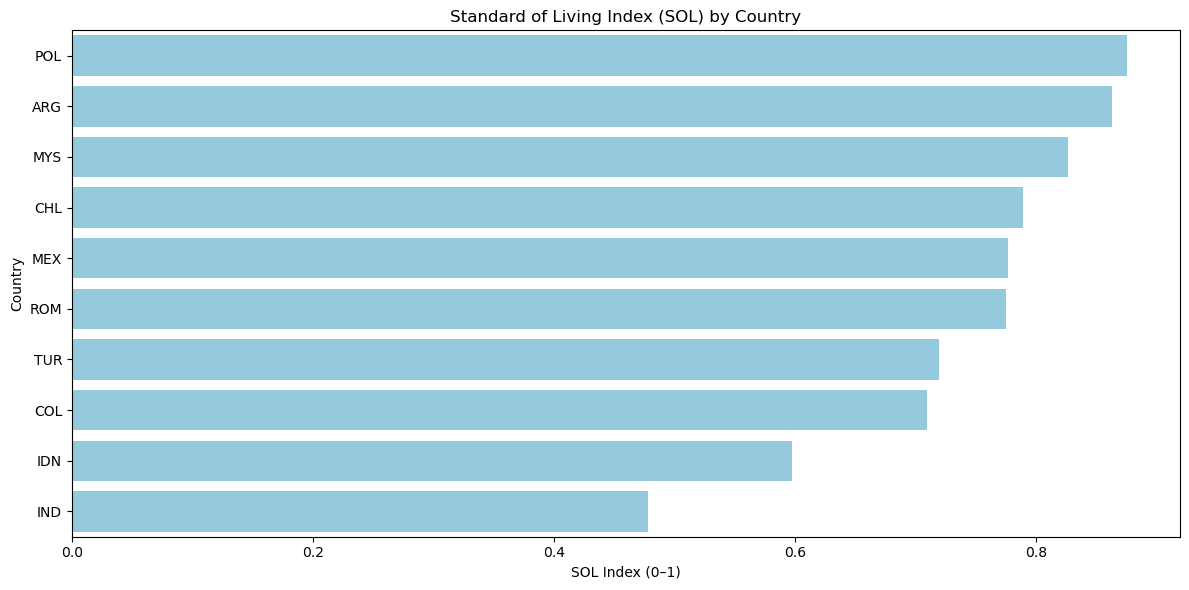

✅ Export complete! File saved as: SOL_Index_by_Country.xlsx


In [32]:

# 5️⃣ VISUALISE RESULTS

country_means_sorted = country_means.sort_values('sol_index', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='sol_index', y=country_col, data=country_means_sorted, color='skyblue')
plt.title("Standard of Living Index (SOL) by Country")
plt.xlabel("SOL Index (0–1)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

output_cols = [
    country_col,
    'education_rate', 'mortality_rate', 'physicians_per_1k', 'gni_per_capita',
    'poverty_rate', 'paved_roads', 'urban_rate', 'sanitation_rate',
    'edu_index', 'health_index', 'physicians_index', 'income_index',
    'poverty_index', 'roads_index', 'urban_index', 'sanitation_index',
    'sol_index'
]

# Create an output DataFrame
export_df = country_means[output_cols].copy()

# Export to a new Excel file
output_path = "SOL_Index_by_Country.xlsx"
export_df.to_excel(output_path, index=False)

print(f"✅ Export complete! File saved as: {output_path}")



In [33]:
df = pd.read_excel("SOL_Index_by_Country.xlsx")

# Drop missing or irrelevant columns
df = df.dropna(subset=["sol_index"])
X = df.select_dtypes(include=["number"]).drop(columns=["sol_index"])
y = df["sol_index"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalise features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest Regressor

In [34]:
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("Random forest - R²:", r2_score(y_test, y_pred_rf))
print("Random forest - MAE:", mean_absolute_error(y_test, y_pred_rf))

Random forest - R²: -3.1505725850410435
Random forest - MAE: 0.01347590414594596


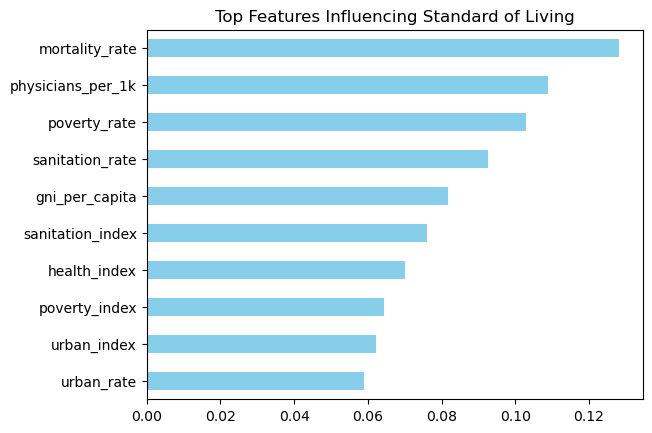

In [35]:
feat_importance = pd.Series(rf.feature_importances_, index=X.columns)
feat_importance.nlargest(10).sort_values().plot(kind='barh', color='skyblue')
plt.title("Top Features Influencing Standard of Living")
plt.show()


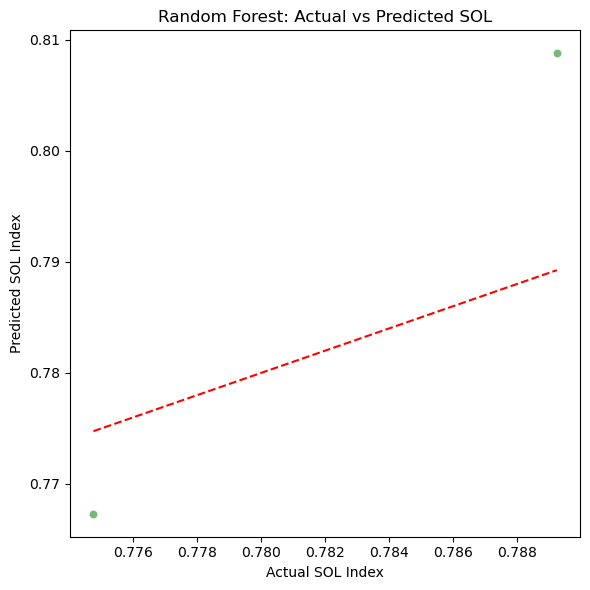

In [36]:


plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_rf, color='forestgreen', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest: Actual vs Predicted SOL")
plt.xlabel("Actual SOL Index")
plt.ylabel("Predicted SOL Index")
plt.tight_layout()
plt.show()

## Decision Tree

Decision Tree — R²: -94.31390689669597
Decision Tree — MAE: 0.07009734688495872


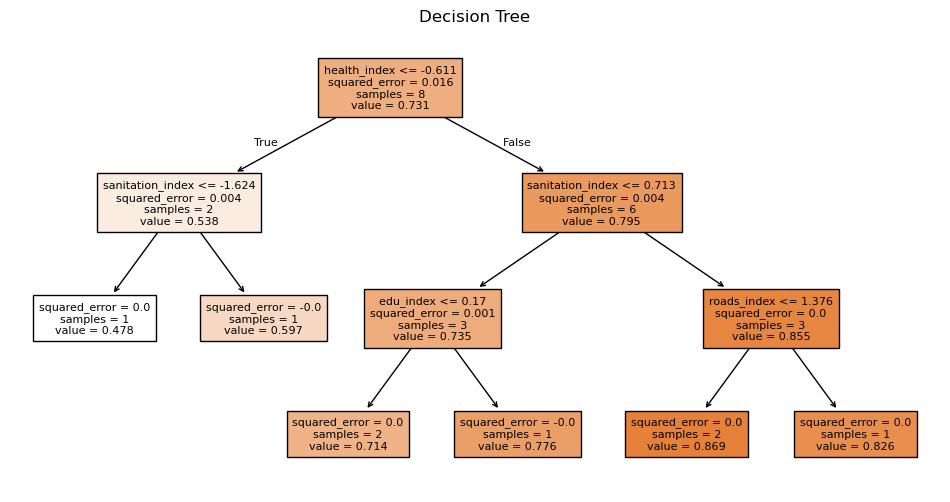

In [37]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

print("Decision Tree — R²:", r2_score(y_test, y_pred_dt))
print("Decision Tree — MAE:", mean_absolute_error(y_test, y_pred_dt))

# Plot (first 3 levels only for readability)
plt.figure(figsize=(12, 6))
plot_tree(dt, max_depth=3, feature_names=X.columns, filled=True, fontsize=8)
plt.title("Decision Tree")
plt.show()


## Gradient Boosting Regressor

In [38]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train_scaled, y_train)
y_pred_gbr = gbr.predict(X_test_scaled)

print("Gradient Boosting — R²:", r2_score(y_test, y_pred_gbr))
print("Gradient Boosting — MAE:", mean_absolute_error(y_test, y_pred_gbr))

Gradient Boosting — R²: -31.48098377176838
Gradient Boosting — MAE: 0.040677597905728224


## Linear Regression

In [39]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Linear Regression — R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression — MAE:", mean_absolute_error(y_test, y_pred_lr))

Linear Regression — R²: 0.9898720911782295
Linear Regression — MAE: 0.0006858685216373228


               Model         R²       MAE
3  Linear Regression   0.989872  0.000686
1      Random Forest  -3.150573  0.013476
2  Gradient Boosting -31.480984  0.040678
0      Decision Tree -94.313907  0.070097


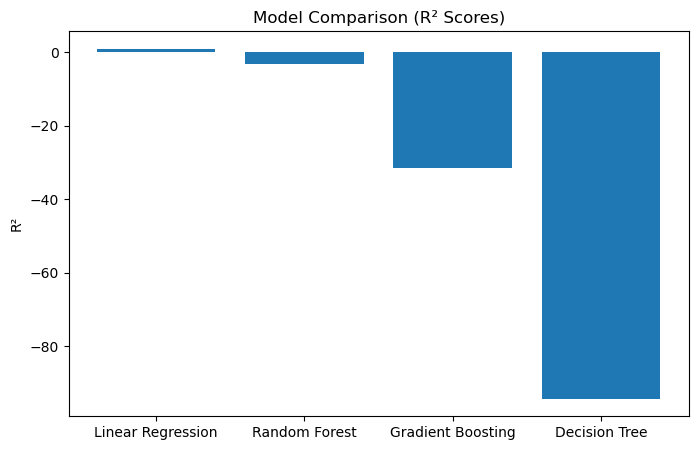

In [40]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Linear Regression'],
    'R²': [r2_score(y_test, y_pred_dt),
           r2_score(y_test, y_pred_rf),
           r2_score(y_test, y_pred_gbr),
           r2_score(y_test, y_pred_lr)],
    'MAE': [mean_absolute_error(y_test, y_pred_dt),
            mean_absolute_error(y_test, y_pred_rf),
            mean_absolute_error(y_test, y_pred_gbr),
            mean_absolute_error(y_test, y_pred_lr)]
}).sort_values('R²', ascending=False)

print(results)

plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['R²'])
plt.title("Model Comparison (R² Scores)")
plt.ylabel("R²")
plt.show()

In [41]:


df = pd.read_excel("Cleaned_Dataset.xlsx")

# Detect key columns automatically
country_col = next((c for c in df.columns if str(c).lower().startswith('country')), None)
year_col = next((c for c in df.columns if 'year' in str(c).lower()), None)
print(f"Detected: {country_col}, {year_col}")

# Required columns mapping (adjust names if needed)
cols = {
    'Primary completion rate, total (% of relevant age group)': 'primary',
    'Under-five mortality rate (per 1,000)': 'under5',
    'Physicians (per 1,000 people)': 'physicians',
    'GNI per capita (Atlas $)': 'gni',
    'Population living below $1.25 a day (% of total)': 'poverty',
    'Paved roads (% of total roads)': 'paved_roads',
    'Urban population': 'urban_pop',
    'Access to improved sanitation (% of total pop.)': 'sanitation'
}

missing = [c for c in cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

df = df.rename(columns=cols)

mort_max = df['under5'].replace(0, np.nan).max() or 1.0
phys_max = df['physicians'].replace(0, np.nan).max() or 1.0

df['E']   = df['primary'] / 100
df['H']   = 1 - (df['under5'] / mort_max)
df['P']   = df['physicians'] / phys_max
df['I']   = df['gni'] / 100
df['Pov'] = 1 - (df['poverty'] / 100)
df['R']   = df['paved_roads'] / 100
df['U']   = df['urban_pop'] / 100
df['S']   = df['sanitation'] / 100


for col in ['E','H','P','I','Pov','R','U','S']:
    df[col] = df[col].clip(0,1)

weights = {'E':0.15,'H':0.15,'P':0.10,'I':0.15,'Pov':0.10,'R':0.10,'U':0.05,'S':0.10}
df['SOL_index'] = sum(df[k]*w for k,w in weights.items())

print(df[[country_col, year_col, 'SOL_index']].head())


Detected: Country code, Year
  Country code  Year  SOL_index
0          ARG  1990   0.766711
1          ARG  1991   0.768411
2          ARG  1992   0.769849
3          ARG  1993   0.770662
4          ARG  1994   0.771606


In [42]:
X = df.select_dtypes(include=np.number).drop(columns=['SOL_index'], errors='ignore')
y = df['SOL_index']


In [43]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [44]:
y_class = pd.qcut(y, q=[0, 1/3, 2/3, 1], labels=['Low','Medium','High'])

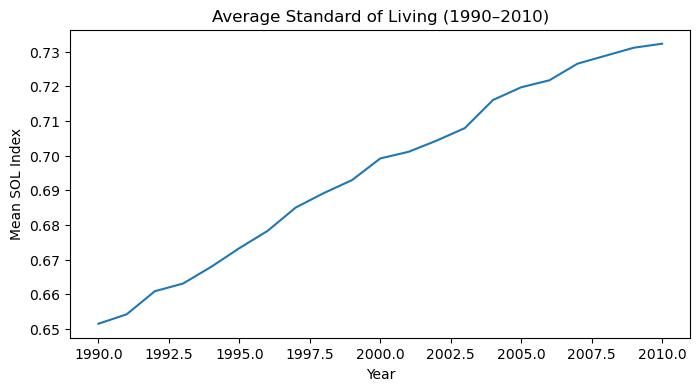

In [45]:

df.groupby(year_col)['SOL_index'].mean().plot(figsize=(8,4))
plt.title("Average Standard of Living (1990–2010)")
plt.xlabel("Year")
plt.ylabel("Mean SOL Index")
plt.show()


End Code
---